In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('../')

In [19]:
from yaml import load as yaml_load
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import pandas as pd
import scipy.stats as st
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

In [11]:
from src.features.build_features import extract_features_classification
from src.data.make_dataset import LoadDataframe
from src.models.train_model import model_classification

In [4]:
def _load_config_file(config_file):
    """
    Load configuration file
    :param config_file: is the configuration file
    :return: configuration
    :rtype: dict
    """
    with open(config_file) as yml_config:
        return yaml_load(yml_config)

def _build_configuration(config_file):
    """
    Build the operation configuration dict
    :param config_file: is the path to the yaml config_file
    :type: string
    :return: config: global configuration
    :rtype dict
    """
    # yaml config
    config = _load_config_file(config_file)
    return config

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.figure(figsize=(15, 15))

In [5]:
config_file = "/home/ml/Documents/crimes_chigaco/config/config.yml"
config = _build_configuration(config_file)

In [6]:
%%time
obj_df_loaded = LoadDataframe(config, '2013', '2014')

CPU times: user 572 µs, sys: 61 µs, total: 633 µs
Wall time: 637 µs


In [7]:
%%time
df_crime_socio = obj_df_loaded.df_crime_socio()

CPU times: user 13min 12s, sys: 2.52 s, total: 13min 15s
Wall time: 16min 26s


In [8]:
df_temperature = obj_df_loaded.df_temperature()

In [9]:
df_sky = obj_df_loaded.df_sky()

In [12]:
obj_features = extract_features_classification(config, df_crime_socio, df_temperature, df_sky)

In [13]:
df_ml = obj_features.extract_feature()

In [14]:
obj_model = model_classification(config, df_ml)

In [15]:
list_data = obj_model.load_for_ml()
X_train = list_data[0]
x_test = list_data[1]
y_train = list_data[2] 
y_test = list_data[3]
class_names = list_data[4]

In [20]:
gboost_param_classification = {
    "n_estimators": st.randint(100, 200),
    "max_depth": st.randint(5,20),
    "gamma": [5,15]}

In [21]:
model_xgboost = obj_model.train_xgboost_(params= gboost_param_classification)

KeyboardInterrupt: 

In [ ]:
preds = model_xgboost.predict(x_test)

In [ ]:
print(precision_score(y_test, preds, average='macro'))

In [ ]:
print(accuracy_score(y_test, preds))

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, preds) 
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figsize = (10, 10)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figsize = (10, 10)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

###  Save model

In [ ]:
filename = '/home/ml/Documents/crimes_chigaco/models/model_xgboost_2013_2014.sav'

In [ ]:
joblib.dump(model_xgboost,filename) 

In [ ]:
loaded_model = joblib.load(filename)

In [ ]:
pred_test = loaded_model.predict(obj_model.dtest())

### Implémentation du SVM

In [ ]:
for_ml = obj_model.load_for_ml()

In [ ]:
X_train = for_ml[0].astype(float)

In [ ]:
y_train = for_ml[2].astype(float)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train.values, y_train.values)

### Implementation de random forest

In [22]:
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [23]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [24]:
n_iter_search = 5
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, cv=5)

In [25]:
%%time
random_search.fit(X_train, y_train)

CPU times: user 7min 59s, sys: 99.4 ms, total: 7min 59s
Wall time: 8min 34s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=None,
          param_distributions={'max_depth': [3, None], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcfb8295400>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcfb8295550>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [26]:
clf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [27]:
random_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 7,
 'min_samples_split': 10}

In [28]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features=7,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [29]:
rf_best = random_search.best_estimator_

In [30]:
preds = rf_best.predict(x_test)

In [31]:
print(accuracy_score(y_test, preds))

0.7022522522522523


Confusion matrix, without normalization
[[11605  1778  8145]
 [ 1087  5531  3624]
 [ 2212  1662 26516]]
Normalized confusion matrix
[[0.54 0.08 0.38]
 [0.11 0.54 0.35]
 [0.07 0.05 0.87]]


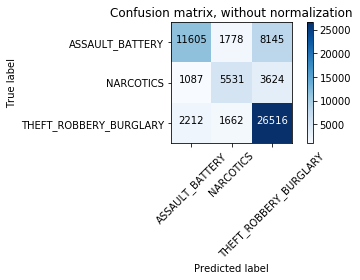

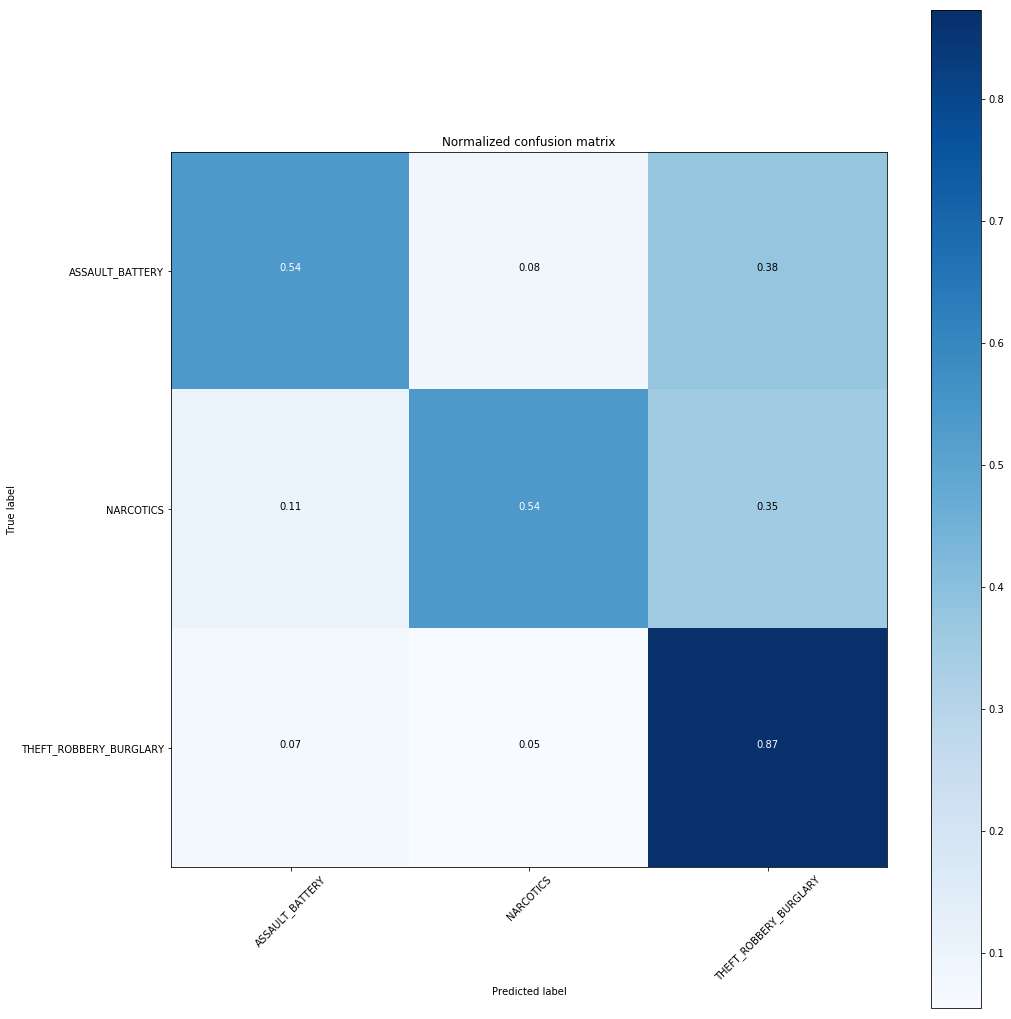

<Figure size 1080x1080 with 0 Axes>

In [32]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, preds) 
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figsize = (10, 10)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figsize = (10, 10)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')